# Classification. Linear models and KNN

In [89]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,KFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression



## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [27]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.losses = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.log(1 + np.exp(-(weights @ x.T) * y)).mean() + (1 / (2 * self.C)) * np.amin((np.linalg.norm(self.weights_))**2)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = -(X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y))))) / len(y) + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            
            self.losses.append(self.get_loss(X_ext,self.weights_,y))
            
            if np.linalg.norm(delta) < self.tol:
                break
            
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [28]:
from sklearn import datasets
from sklearn import metrics

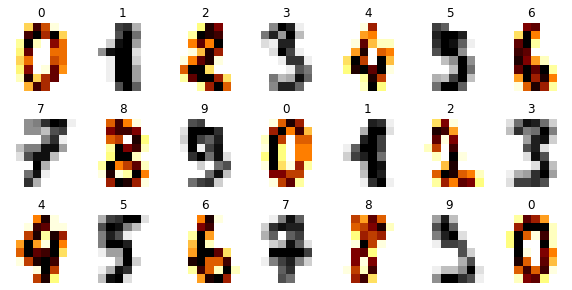

In [29]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [30]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [31]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [32]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [33]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [34]:
lr_clf.fit(X_train, y_train)

In [35]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [36]:
model = CustomLogisticRegression()

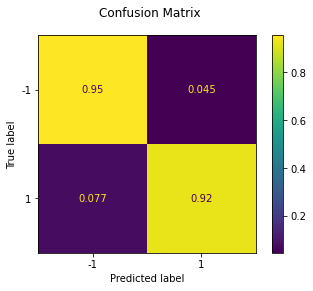

In [37]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [38]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [39]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

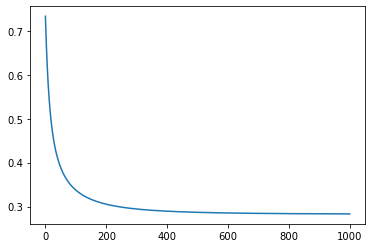

In [41]:
sns.lineplot(x=np.arange(len(model.losses)),y=model.losses)
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

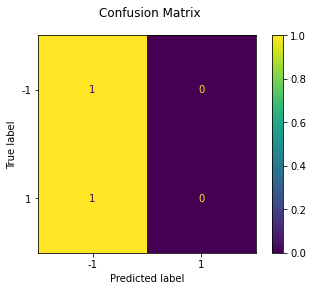

(0.4968684759916493, 0.49166666666666664)

In [42]:
logisticModel = CustomLogisticRegression(eta=0.2)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

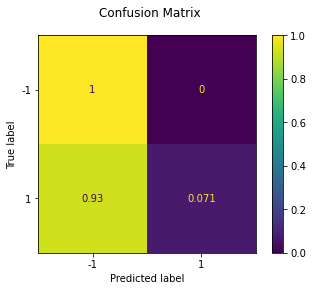

(0.5455810716771051, 0.5277777777777778)

In [43]:
logisticModel = CustomLogisticRegression(eta=0.1)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

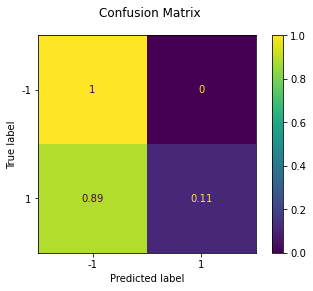

(0.5671537926235213, 0.55)

In [44]:
logisticModel = CustomLogisticRegression(eta=0.05)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

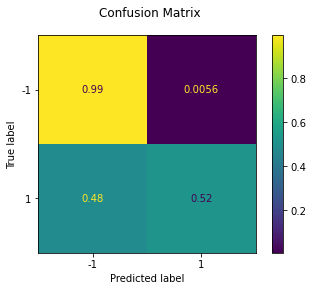

(0.7731384829505915, 0.7527777777777778)

In [45]:
logisticModel = CustomLogisticRegression(eta=0.01)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

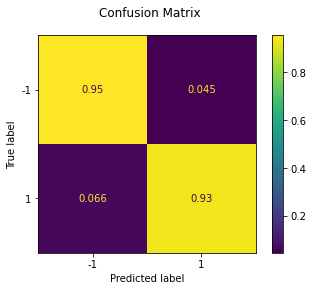

(0.9157967988865693, 0.9444444444444444)

In [46]:
logisticModel = CustomLogisticRegression(eta=0.005)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

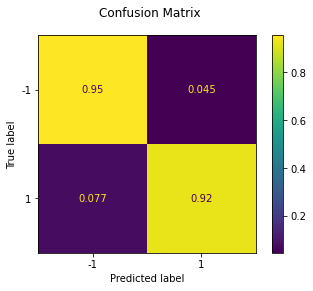

(0.9109255393180237, 0.9388888888888889)

In [47]:
logisticModel = CustomLogisticRegression(eta=0.001)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

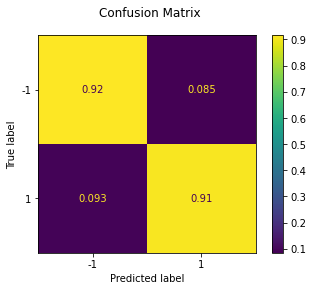

(0.8844815588030619, 0.9111111111111111)

In [48]:
logisticModel = CustomLogisticRegression(eta=0.0001)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

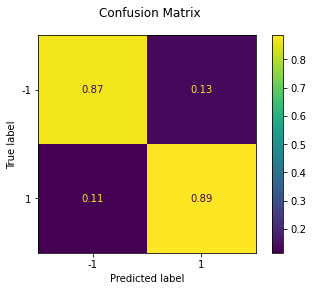

(0.848990953375087, 0.8777777777777778)

In [49]:
logisticModel = CustomLogisticRegression(eta=0.00001)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

From the matrices obtained above, it can be seen that the quality of the results obtained depends on the value of ETA and this variable must be carefully selected. Too big or too small value is not always good. In our case, we got the best result when ETA = 0.005 

**(0.5 points)** Try different regularization parameter values and compare the model quality.

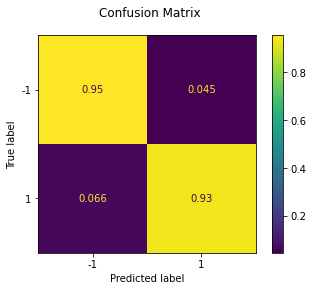

(0.9151009046624913, 0.9444444444444444)

In [50]:
logisticModel = CustomLogisticRegression(C=5)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

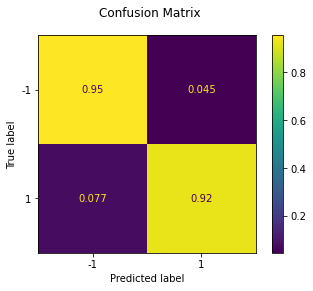

(0.9109255393180237, 0.9388888888888889)

In [51]:
logisticModel = CustomLogisticRegression(C=1)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

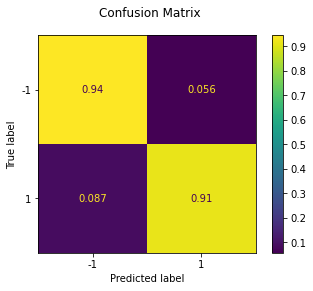

(0.9039665970772442, 0.9277777777777778)

In [52]:
logisticModel = CustomLogisticRegression(C=0.5)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

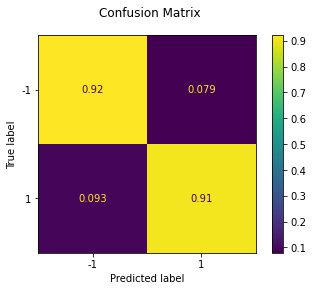

(0.8879610299234516, 0.9138888888888889)

In [53]:
logisticModel = CustomLogisticRegression(C=0.1)
fit_evaluate(logisticModel, X_train, y_train, X_test, y_test)

The regularization parameter is an important thing, the value of which must be chosen carefully, because the quality of the results obtained depends on this. 


**(0.5 points)** Compare zero initialization and random initialization. 

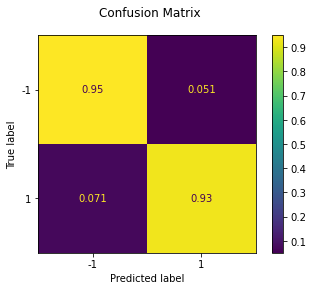

(0.9116214335421016, 0.9388888888888889)


In [54]:
logisticModel = CustomLogisticRegression(zero_init=True)
print(fit_evaluate(logisticModel, X_train, y_train, X_test, y_test))

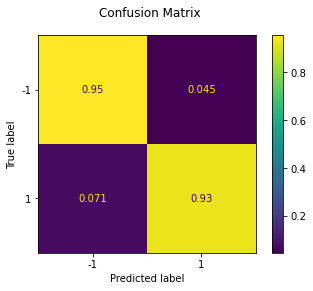

(0.9116214335421016, 0.9416666666666667)


In [55]:
logisticModel = CustomLogisticRegression(random_state=0)
print(fit_evaluate(logisticModel, X_train, y_train, X_test, y_test))

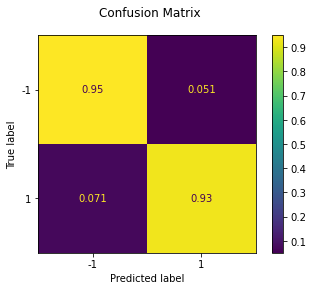

(0.9109255393180237, 0.9388888888888889)


In [56]:
logisticModel = CustomLogisticRegression(random_state=10)
print(fit_evaluate(logisticModel, X_train, y_train, X_test, y_test))

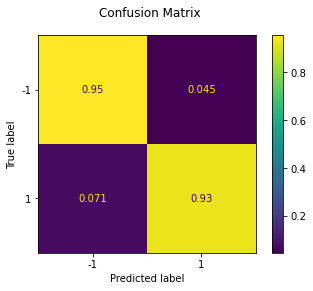

(0.9116214335421016, 0.9416666666666667)


In [57]:
logisticModel = CustomLogisticRegression(random_state=30)
print(fit_evaluate(logisticModel, X_train, y_train, X_test, y_test))

Both with zero and with random initialization, the results are very similar. But in some cases, with random initialization, the results are better. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [401]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return metrics.pairwise.euclidean_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        all_weights = []
        for oneclass in self.classes_:
            sum_of_weights = 0
            for num in range(len(y)):
                if y[num] == oneclass:
                    sum_of_weights += weights[num]
            all_weights.append(sum_of_weights)
        return all_weights
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        max_value = self.predict_proba(X).argmax(axis=1)
        return max_value 

In [402]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [403]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [404]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

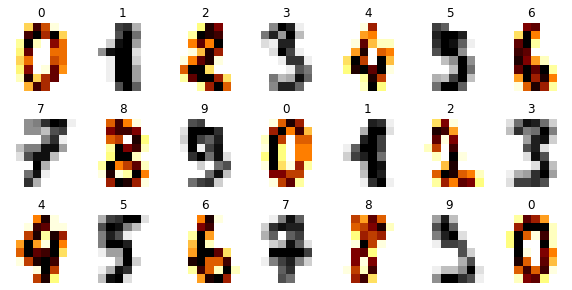

In [405]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [406]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

#### Unfortunately, in the CustomKNeighborsClassifier class, I could not implement the predict_proba method, so I use the built-in model for further research 

In [410]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
model = KNeighborsClassifier(n_neighbors=5, weights='distance')

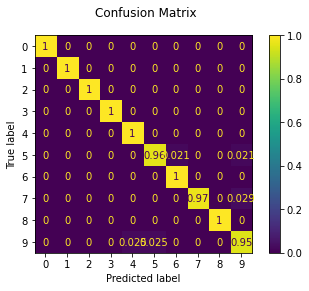

In [411]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [412]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Sometimes the model confuses the numbers 5 and 6, 5 and 9, 7 and 9. This happens because they are a bit similar 

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

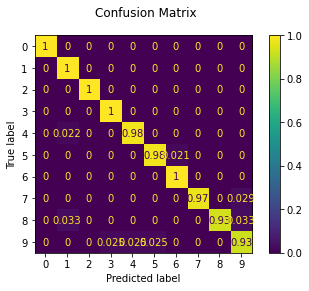

In [413]:
model = KNeighborsClassifier(n_neighbors=1, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

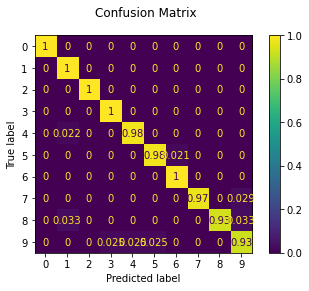

In [414]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

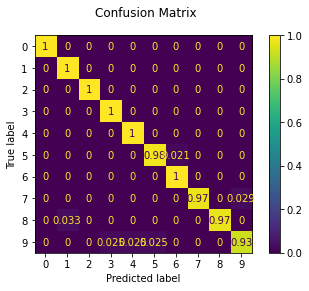

In [415]:
model = KNeighborsClassifier(n_neighbors=3, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

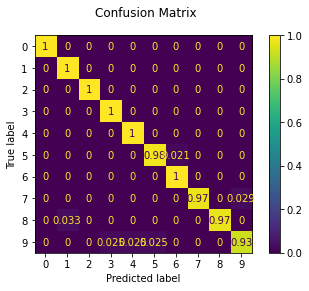

In [416]:
model = KNeighborsClassifier(n_neighbors=4, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

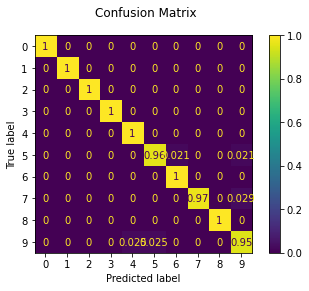

In [417]:
model = KNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

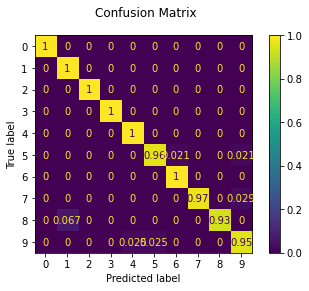

In [418]:
model = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

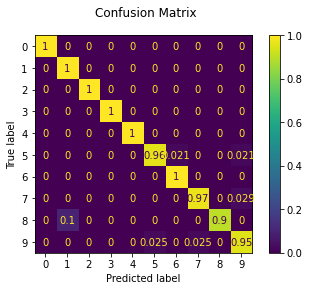

In [419]:
model = KNeighborsClassifier(n_neighbors=15, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

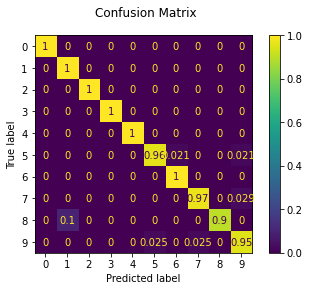

In [420]:
model = KNeighborsClassifier(n_neighbors=20, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

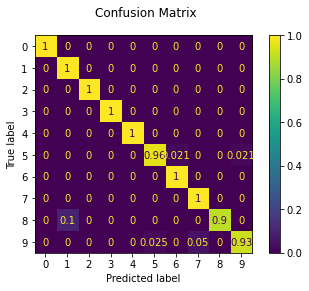

In [421]:
model = KNeighborsClassifier(n_neighbors=25, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

From the resulting matrices, you can see that the quality of the model depends on the value of n_neighbors. This value must be carefully selected, because with a strong increase, the quality get worse  (in our case, the model starts to confuse the numbers 8 and 1)

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

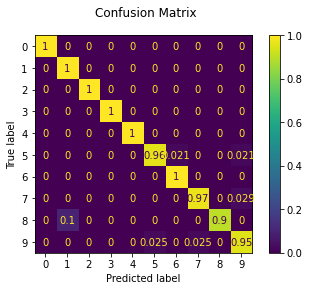

In [427]:
model = KNeighborsClassifier(n_neighbors=20, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

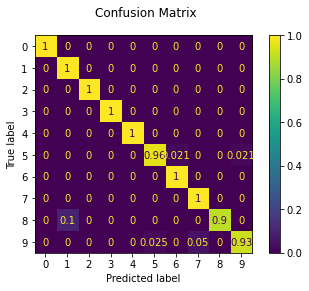

In [428]:
model = KNeighborsClassifier(n_neighbors=20, weights='uniform')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)


With n_neighbors = 5, the matrices are the same, however, with an increase of n_neighbors, the model with uniform shows itself better than the model with distance

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

We also can use Manhattan distance. Manhattan distance is a distance metric between two points in a N dimensional vector space. It is the sum of the lengths of the projections of the line segment between the points onto the coordinate axes. In simple terms, it is the sum of absolute difference between the measures in all dimensions of two points.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [155]:
PATH = "./data/"

In [156]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [157]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [390]:
import warnings
warnings.filterwarnings('ignore')

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [64]:
data.duplicated().sum()

0

In [65]:
data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

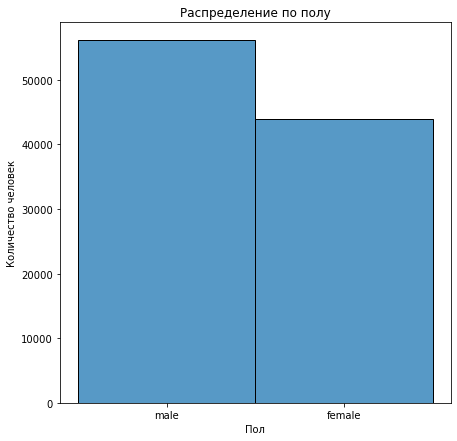

In [66]:
figure = plt.figure(figsize=(7, 7))

plt.title("Распределение по полу")
sns.histplot(data=data, x=data['Sex'], multiple="dodge", bins = 3)
plt.xlabel("Пол")
plt.ylabel("Количество человек")
plt.show()

In [67]:
data.Survived.value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

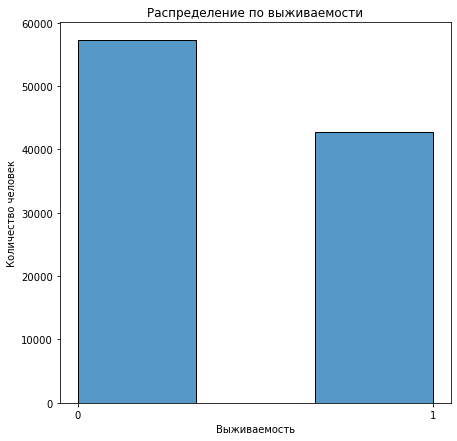

In [68]:
figure = plt.figure(figsize=(7, 7))

plt.xticks(range(0, 2))
plt.title("Распределение по выживаемости")
sns.histplot(data=data, x=data['Survived'], multiple="dodge", bins = 3)
plt.xlabel("Выживаемость")
plt.ylabel("Количество человек")
plt.show()

In [69]:
data.groupby('Sex')['Survived'].mean()

Sex
female    0.711525
male      0.205795
Name: Survived, dtype: float64

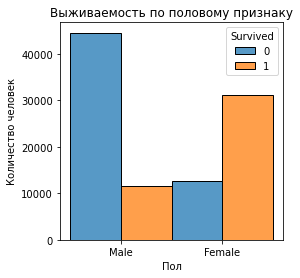

In [70]:
figure = plt.figure(figsize=(4, 4))

plt.title("Выживаемость по половому признаку")
plt.xticks(range(0, 2), ['Male', 'Female'])
sns.histplot(data=data, x=data['Sex'], hue=data['Survived'], multiple="dodge")
plt.xlabel("Пол")
plt.ylabel("Количество человек")
plt.show()

According to the graph, you can see that women survived much more than men (almost 2.5 times). Men died 4 times more than women. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

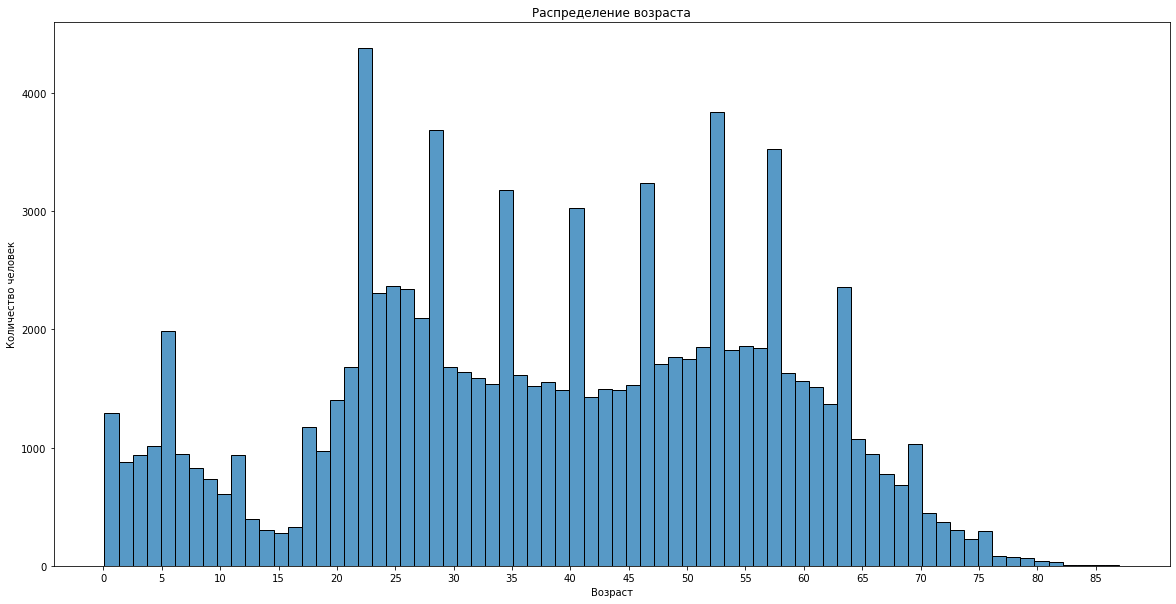

In [71]:
figure = plt.figure(figsize=(20, 10))

plt.xticks(range(0, 88, 5))
plt.title("Распределение возраста")
sns.histplot(data=data, x=data['Age'], multiple="dodge")
plt.xlabel("Возраст")
plt.ylabel("Количество человек")
plt.show()

In [72]:
avAge = data['Age'].mean() 
avAgeSurv = data[data['Survived'] == 1]['Age'].mean()
avAgeDec = data[data['Survived'] == 0]['Age'].mean()
medAge = data['Age'].median()
medAgeSurv = data[data['Survived'] == 1]['Age'].median()
medAgeDec = data[data['Survived'] == 0]['Age'].median()
print(f'The average age of passengers: {avAge} ')
print(f'The average age of survived passengers: {avAgeSurv}')
print(f'The average age of deceased passengers: {avAgeDec}')
print(f'The median age of passengers: {medAge}')
print(f'The median age of survived passengers: {medAgeSurv}')
print(f'The median age of deceased passengers: {medAgeDec}')



The average age of passengers: 38.35547214294576 
The average age of survived passengers: 40.55379931430776
The average age of deceased passengers: 36.708694881533724
The median age of passengers: 39.0
The median age of survived passengers: 43.0
The median age of deceased passengers: 36.0


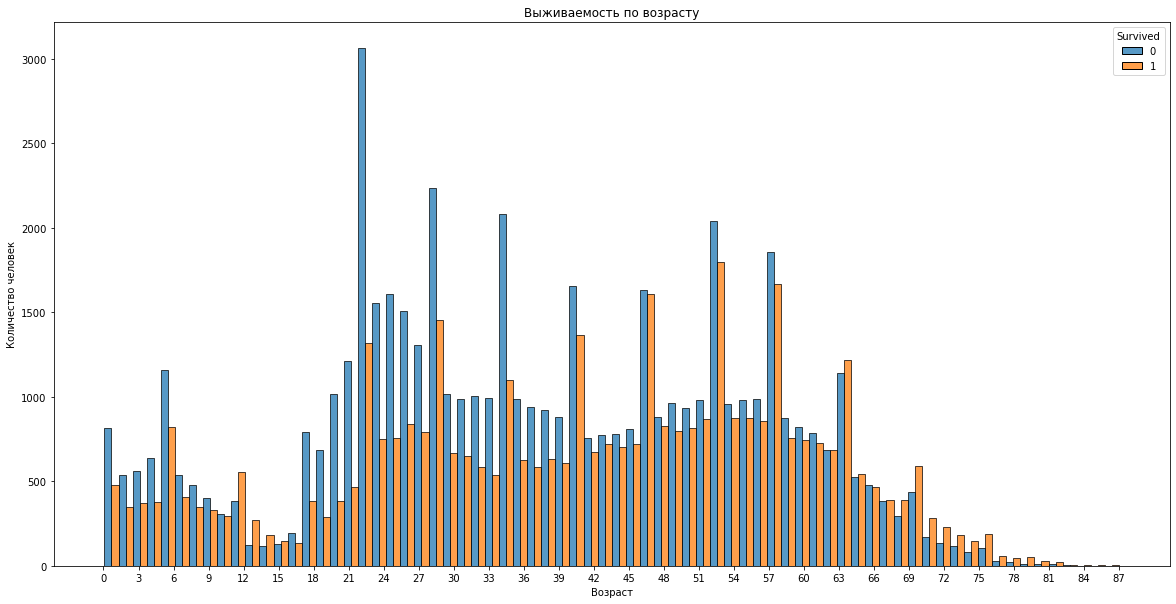

In [73]:
figure = plt.figure(figsize=(20, 10))

plt.xticks(range(0, 88, 3))
plt.title("Выживаемость по возрасту")
sns.histplot(data=data, x=data['Age'], hue=data['Survived'], multiple="dodge")
plt.xlabel("Возраст")
plt.ylabel("Количество человек")
plt.show()

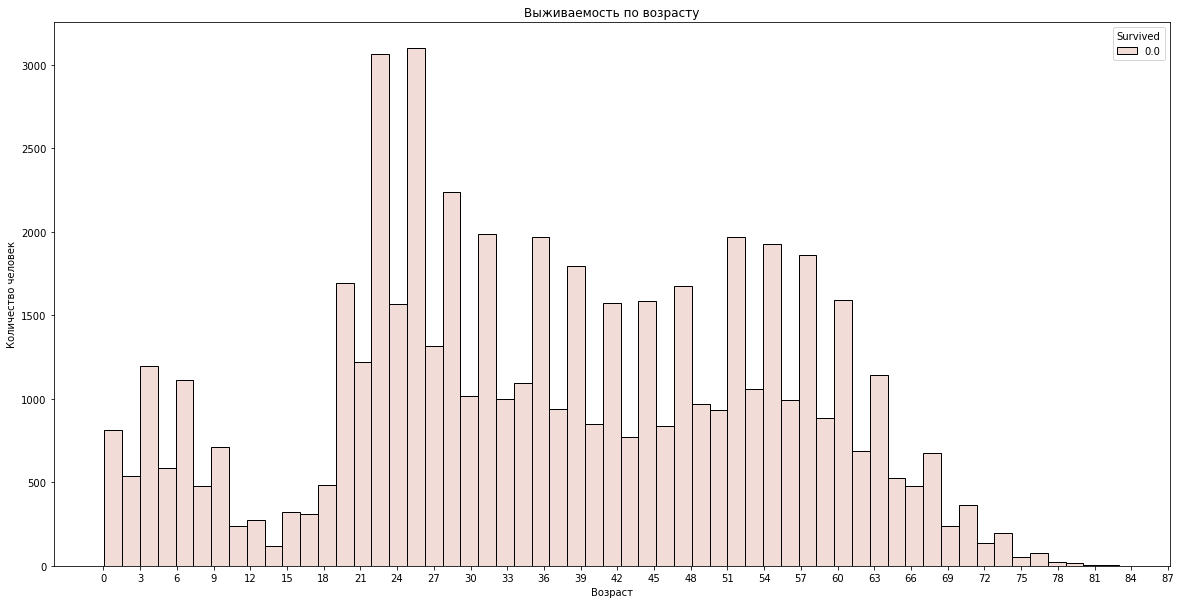

In [74]:
figure = plt.figure(figsize=(20, 10))

plt.xticks(range(0, 88, 3))
plt.title("Выживаемость по возрасту")
sns.histplot(data=data, x=data['Age'], hue=data[data['Survived'] == 0]['Survived'], multiple="dodge")
plt.xlabel("Возраст")
plt.ylabel("Количество человек")
plt.show()

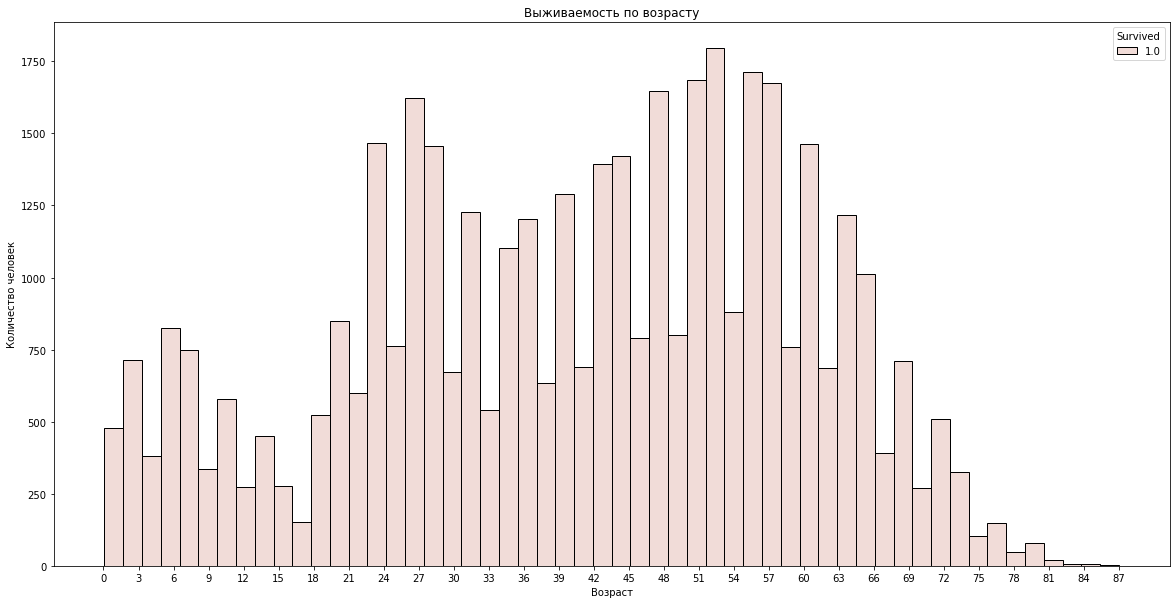

In [75]:
figure = plt.figure(figsize=(20, 10))

plt.xticks(range(0, 88, 3))
plt.title("Выживаемость по возрасту")
sns.histplot(data=data, x=data['Age'], hue=data[data['Survived'] == 1]['Survived'], multiple="dodge")
plt.xlabel("Возраст")
plt.ylabel("Количество человек")
plt.show()

Based on the data obtained, it can be said that, first of all, they saved the elderly and children, because they have a higher ratio of survivors to non-survivors. Average age of survivors is higher than average age of non-survivors 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [76]:
data.Pclass.value_counts()

3    41006
1    30315
2    28679
Name: Pclass, dtype: int64

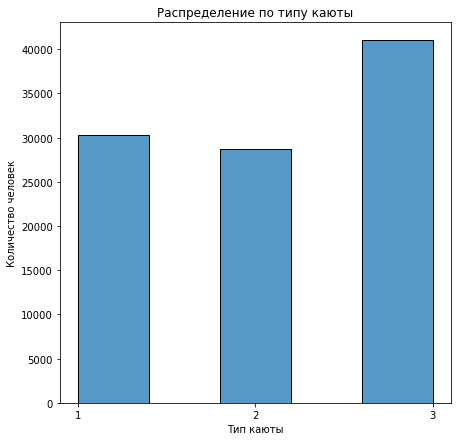

In [77]:
figure = plt.figure(figsize=(7, 7))

plt.xticks(range(1, 4))
plt.title("Распределение по типу каюты")
sns.histplot(data=data, x=data['Pclass'], multiple="dodge", bins = 5)
plt.xlabel("Тип каюты")
plt.ylabel("Количество человек")
plt.show()

In [78]:
data.groupby('Pclass')['Survived'].mean()

Pclass
1    0.579779
2    0.525018
3    0.247305
Name: Survived, dtype: float64

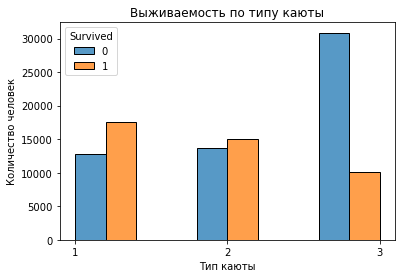

In [79]:
figure = plt.figure(figsize=(6, 4))

plt.title("Выживаемость по типу каюты")
plt.xticks(range(1, 4))
sns.histplot(data=data, x=data['Pclass'], hue=data['Survived'], multiple="dodge", bins=5)
plt.xlabel("Тип каюты")
plt.ylabel("Количество человек")
plt.show()

In [83]:
data.Embarked.value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

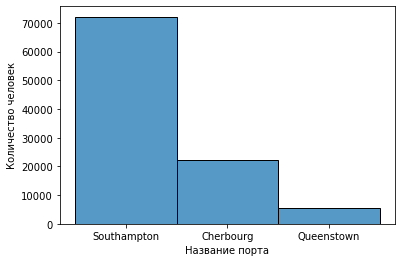

In [84]:
figure = plt.figure(figsize=(6, 4))


sns.histplot(data=data, x=data['Embarked'], bins=5)
plt.xticks(range(0, 3), ['Southampton', 'Cherbourg', 'Queenstown'])
plt.xlabel("Название порта")
plt.ylabel("Количество человек")
plt.show()

In [85]:
data.groupby('Embarked')['Survived'].mean()

Embarked
C    0.751296
Q    0.596976
S    0.315294
Name: Survived, dtype: float64

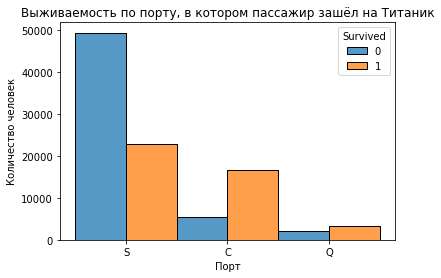

In [86]:
figure = plt.figure(figsize=(6, 4))

plt.title("Выживаемость по порту, в котором пассажир зашёл на Титаник")

sns.histplot(data=data, x=data['Embarked'], hue=data['Survived'], multiple="dodge")
plt.xlabel("Порт")
plt.ylabel("Количество человек")
plt.show()

Most people had 3rd class.

The graph shows that the survival rate for third class passengers is lower than the survival rate for first and second class passengers (possibly because the price of a first and second class ticket is higher). But 1st class was the safest.

The bulk of the people went to the Titanic in the port of Southampton.

Passengers who entered Southampton had the least chance of survival. Passengers who entered Cherbourg were most likely to survive.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [87]:
data.isna().mean()

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64

Missing values by Age - 3,3%, by Ticket - 4,6%, by Fare - 1,3%, by Cabin - 67,9%, by Embarked - 2,5%

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can fill in the missing values with the median values. Especially this method will be good for filling gender and class fields. You can also fill the missing values with the mean value. Of course, there are some disadvantages of these methods, because we cannot accurately predict what values were actually there 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [346]:
PATH = "./data/"
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))

In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [348]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Pclass       100000 non-null  int64  
 2   Name         100000 non-null  object 
 3   Sex          100000 non-null  object 
 4   Age          96513 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
 7   Ticket       94819 non-null   object 
 8   Fare         99867 non-null   float64
 9   Cabin        29169 non-null   object 
 10  Embarked     99723 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.4+ MB


#### Fill in empty values 

In [349]:
mAgefem1 = test_data['Age'][(test_data.Sex=='female') & (test_data.Pclass==1)].median()
mAgefem2 = test_data['Age'][(test_data.Sex=='female') & (test_data.Pclass==2)].median()
mAgefem3 = test_data['Age'][(test_data.Sex=='female') & (test_data.Pclass==3)].median()
mAgemale1 = test_data['Age'][(test_data.Sex=='male') & (test_data.Pclass==1)].median()
mAgemale2 = test_data['Age'][(test_data.Sex=='male') & (test_data.Pclass==2)].median()
mAgemale3 = test_data['Age'][(test_data.Sex=='male') & (test_data.Pclass==3)].median()

test_data.loc[(test_data.Sex=='female') & (test_data.Pclass==1) & (pd.isna(test_data.Age)), 'Age'] = mAgefem1
test_data.loc[(test_data.Sex=='female') & (test_data.Pclass==2) & (pd.isna(test_data.Age)), 'Age'] = mAgefem2
test_data.loc[(test_data.Sex=='female') & (test_data.Pclass==3) & (pd.isna(test_data.Age)), 'Age'] = mAgefem3
test_data.loc[(test_data.Sex=='male') & (test_data.Pclass==1) & (pd.isna(test_data.Age)), 'Age'] = mAgemale1
test_data.loc[(test_data.Sex=='male') & (test_data.Pclass==2) & (pd.isna(test_data.Age)), 'Age'] = mAgemale2
test_data.loc[(test_data.Sex=='male') & (test_data.Pclass==3) & (pd.isna(test_data.Age)), 'Age'] = mAgemale3

In [350]:
mAgefem1 = test_data['Fare'][(test_data.Sex=='female') & (test_data.Pclass==1)].median()
mAgefem2 = test_data['Fare'][(test_data.Sex=='female') & (test_data.Pclass==2)].median()
mAgefem3 = test_data['Fare'][(test_data.Sex=='female') & (test_data.Pclass==3)].median()
mAgemale1 = test_data['Fare'][(test_data.Sex=='male') & (test_data.Pclass==1)].median()
mAgemale2 = test_data['Fare'][(test_data.Sex=='male') & (test_data.Pclass==2)].median()
mAgemale3 = test_data['Fare'][(test_data.Sex=='male') & (test_data.Pclass==3)].median()

test_data.loc[(test_data.Sex=='female') & (test_data.Pclass==1) & (pd.isna(test_data.Fare)), 'Fare'] = mAgefem1
test_data.loc[(test_data.Sex=='female') & (test_data.Pclass==2) & (pd.isna(test_data.Fare)), 'Fare'] = mAgefem2
test_data.loc[(test_data.Sex=='female') & (test_data.Pclass==3) & (pd.isna(test_data.Fare)), 'Fare'] = mAgefem3
test_data.loc[(test_data.Sex=='male') & (test_data.Pclass==1) & (pd.isna(test_data.Fare)), 'Fare'] = mAgemale1
test_data.loc[(test_data.Sex=='male') & (test_data.Pclass==2) & (pd.isna(test_data.Fare)), 'Fare'] = mAgemale2
test_data.loc[(test_data.Sex=='male') & (test_data.Pclass==3) & (pd.isna(test_data.Fare)), 'Fare'] = mAgemale3


In [351]:
mAgefem1 = data['Age'][(data.Sex=='female') & (data.Pclass==1)].median()
mAgefem2 = data['Age'][(data.Sex=='female') & (data.Pclass==2)].median()
mAgefem3 = data['Age'][(data.Sex=='female') & (data.Pclass==3)].median()
mAgemale1 = data['Age'][(data.Sex=='male') & (data.Pclass==1)].median()
mAgemale2 = data['Age'][(data.Sex=='male') & (data.Pclass==2)].median()
mAgemale3 = data['Age'][(data.Sex=='male') & (data.Pclass==3)].median()

data.loc[(data.Sex=='female') & (data.Pclass==1) & (pd.isna(data.Age)), 'Age'] = mAgefem1
data.loc[(data.Sex=='female') & (data.Pclass==2) & (pd.isna(data.Age)), 'Age'] = mAgefem2
data.loc[(data.Sex=='female') & (data.Pclass==3) & (pd.isna(data.Age)), 'Age'] = mAgefem3
data.loc[(data.Sex=='male') & (data.Pclass==1) & (pd.isna(data.Age)), 'Age'] = mAgemale1
data.loc[(data.Sex=='male') & (data.Pclass==2) & (pd.isna(data.Age)), 'Age'] = mAgemale2
data.loc[(data.Sex=='male') & (data.Pclass==3) & (pd.isna(data.Age)), 'Age'] = mAgemale3

In [352]:
mAgefem1 = data['Fare'][(data.Sex=='female') & (data.Pclass==1)].median()
mAgefem2 = data['Fare'][(data.Sex=='female') & (data.Pclass==2)].median()
mAgefem3 = data['Fare'][(data.Sex=='female') & (data.Pclass==3)].median()
mAgemale1 = data['Fare'][(data.Sex=='male') & (data.Pclass==1)].median()
mAgemale2 = data['Fare'][(data.Sex=='male') & (data.Pclass==2)].median()
mAgemale3 = data['Fare'][(data.Sex=='male') & (data.Pclass==3)].median()

data.loc[(data.Sex=='female') & (data.Pclass==1) & (pd.isna(data.Fare)), 'Fare'] = mAgefem1
data.loc[(data.Sex=='female') & (data.Pclass==2) & (pd.isna(data.Fare)), 'Fare'] = mAgefem2
data.loc[(data.Sex=='female') & (data.Pclass==3) & (pd.isna(data.Fare)), 'Fare'] = mAgefem3
data.loc[(data.Sex=='male') & (data.Pclass==1) & (pd.isna(data.Fare)), 'Fare'] = mAgemale1
data.loc[(data.Sex=='male') & (data.Pclass==2) & (pd.isna(data.Fare)), 'Fare'] = mAgemale2
data.loc[(data.Sex=='male') & (data.Pclass==3) & (pd.isna(data.Fare)), 'Fare'] = mAgemale3

In [353]:
data.loc[(pd.isna(data.Embarked)), 'Embarked'] = 0
test_data.loc[(pd.isna(test_data.Embarked)), 'Embarked'] = 0

In [354]:
finData = data.drop(columns=['Ticket', 'Cabin', 'Name', 'PassengerId'])

In [355]:
sex = {"male": 0, "female": 1}
finData['Sex'] = finData['Sex'].map(sex)
Embarked = {"S": 0, "C": 1, "Q": 2}
finData['Embarked'] = finData['Embarked'].map(Embarked)
finData.loc[(pd.isna(finData.Embarked)), 'Embarked'] = 0

In [356]:
finData['Age'] = finData['Age'].astype(np.int64)
finData['Fare'] = finData['Fare'].astype(np.int64)
finData['Embarked'] = finData['Embarked'].astype(np.int64)

In [366]:
finData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Survived  100000 non-null  int64
 1   Pclass    100000 non-null  int64
 2   Sex       100000 non-null  int64
 3   Age       100000 non-null  int64
 4   SibSp     100000 non-null  int64
 5   Parch     100000 non-null  int64
 6   Fare      100000 non-null  int64
 7   Embarked  100000 non-null  int64
dtypes: int64(8)
memory usage: 6.1 MB


In [358]:
finTestData = test_data.drop(columns=['Ticket', 'Cabin', 'Name', 'PassengerId'])

In [359]:
sex = {"male": 0, "female": 1}
finTestData['Sex'] = finTestData['Sex'].map(sex)
Embarked = {"S": 0, "C": 1, "Q": 2}
finTestData['Embarked'] = finTestData['Embarked'].map(Embarked)
finTestData.loc[(pd.isna(finTestData.Embarked)), 'Embarked'] = 0

In [360]:
finTestData['Age'] = finTestData['Age'].astype(np.int64)
finTestData['Fare'] = finTestData['Fare'].astype(np.int64)
finTestData['Embarked'] = finTestData['Embarked'].astype(np.int64)

In [361]:
finTestData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Pclass    100000 non-null  int64
 1   Sex       100000 non-null  int64
 2   Age       100000 non-null  int64
 3   SibSp     100000 non-null  int64
 4   Parch     100000 non-null  int64
 5   Fare      100000 non-null  int64
 6   Embarked  100000 non-null  int64
dtypes: int64(7)
memory usage: 5.3 MB


In [362]:
target = finData["Survived"]

In [367]:
finData = finData.drop(columns=['Survived'])

In [382]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000000)
log_model.fit(finData, target)
y_pred1 = log_model.predict(finTestData)
acc_log = log_model.score(finData, target)
acc_log

0.75822

In [392]:
scores = cross_val_score(logreg, finData, target,  scoring = "accuracy",)
scores


array([0.7567 , 0.76235, 0.7576 , 0.7554 , 0.75975])

In [386]:
knn = KNeighborsClassifier(n_neighbors=25, weights='distance', n_jobs=-1)
knn.fit(finData, target)
y_pred2 = knn.predict(finTestData)
acc_knn = knn.score(finData, target)
acc_knn

0.91274

In [393]:
scores = cross_val_score(knn, finData, target, scoring = "accuracy")
scores

array([0.7206 , 0.7193 , 0.71875, 0.71835, 0.71965])

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [394]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data.PassengerId
submission['Survived'] = y_pred1
submission.to_csv('data/titanic/submission.csv', index=False)

In [396]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   PassengerId  100000 non-null  int64
 1   Survived     100000 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


In [397]:
submission.head()

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

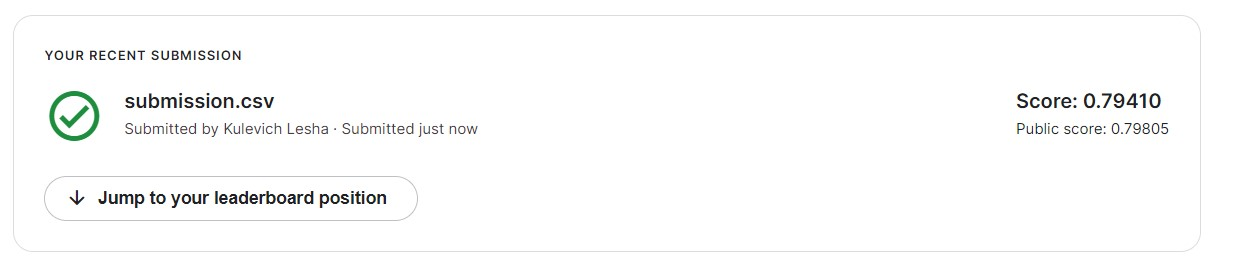

In [399]:
from IPython.display import Image
Image('result.jpg')